In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## loading and Preprocessing Dataset

* Loading the galaxy cluster Dataset. Dataset avaiable at https://arxiv.org/pdf/astro-ph/0512349.pdf
* Dataset has cluster name, redshift value, Angular diameter distance, error min and error max value.

In [ ]:
df_bon = pd.read_excel('/content/drive/MyDrive/Thesis/Gc_data_true.xlsx')
df_bon.shape[0]
# df_bon = df_bon.sort_values(by=['z'])

38

In [ ]:
df_bon.tail()

,cluster,z,d_a,e_max,e_min
33,MS2053.7-0449,0.582,2.48,0.41,0.44
34,RXJ1347.5-1145,0.451,0.96,0.06,0.08
35,RXJ1716.4+6708,0.813,1.04,0.51,0.43
36,RXJ2129.7+0005,0.235,0.46,0.11,0.08
37,ZW3146,0.291,0.83,0.02,0.02


In [ ]:
# df_dropped = df_bon.drop('Unnamed: 0', axis=1)
# df_dropped.tail()

#####  symmetrizing the error

In [ ]:
X = df_bon['z'].to_numpy()
y = df_bon['d_a'].to_numpy()
error_max = df_bon['e_max'].to_numpy()
error_min = df_bon['e_min'].to_numpy()

In [ ]:
def symmetrizing_the_error(e_max,e_min):
    result = np.where(e_max==e_min, e_max, (e_max-(e_max-e_min)/2))
    return result

In [ ]:
error=symmetrizing_the_error(error_max,error_min)

In [ ]:
df_bon['error'] = pd.DataFrame(error)
df_bon.tail()

,cluster,z,d_a,e_max,e_min,error
33,MS2053.7-0449,0.582,2.48,0.41,0.44,0.425
34,RXJ1347.5-1145,0.451,0.96,0.06,0.08,0.070
35,RXJ1716.4+6708,0.813,1.04,0.51,0.43,0.470
36,RXJ2129.7+0005,0.235,0.46,0.11,0.08,0.095
37,ZW3146,0.291,0.83,0.02,0.02,0.020


In [ ]:
# Specify the file path
file_path = '/content/drive/MyDrive/Thesis/Gc_data_sym_error.xlsx'

# Save the DataFrame as an Excel file at the specified path
df_bon.to_excel(file_path, index=False)

# Gc_data_sym_error.xlsx is already there

* galaxy cluster Dataset with symmetric error.
* for eg: if error_max is 0.41 and error_min is 0.44 then it will be considered as 0.425.

In [ ]:
df_bon = pd.read_excel('/content/drive/MyDrive/Thesis/Gc_data_sym_error.xlsx')
z = df_bon['z'].to_numpy()
d_a = df_bon['d_a'].to_numpy()
error_max = df_bon['e_max'].to_numpy()
error_min = df_bon['e_min'].to_numpy()
error=df_bon['error'].to_numpy()

In [ ]:
z.shape,d_a.shape,error.shape

((38,), (38,), (38,))

<ipython-input-13-caff4ffbbb4f>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(z, d_a, error, fmt='.k', color='black',


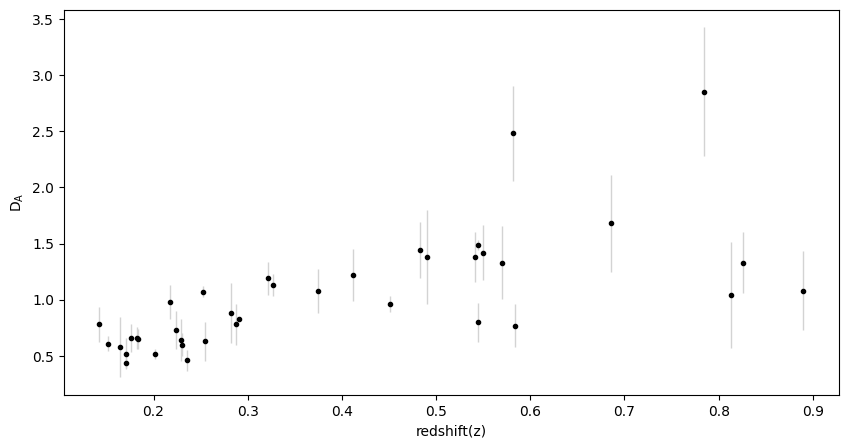

In [ ]:
plt.figure(figsize=(10,5))
plt.errorbar(z, d_a, error, fmt='.k', color='black',
             ecolor='lightgray', elinewidth=1, capsize=0);
plt.xlabel('redshift(z)')
plt.ylabel('$\mathregular{D_A}$')
plt.show()

# GPR

* Using GPR finding the relation between the redshift and Angular diameter distance.

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, WhiteKernel, DotProduct

In [ ]:
# all 38 cluster will be used for training
z_train = z.reshape(-1, 1)
d_a_train = d_a

In [ ]:
np.min(z_train),np.max(z_train)

(0.142, 0.89)

In [ ]:
# input for predictions
z_pred = np.linspace(0.14, 0.89, 1000).reshape(-1,1)

In [ ]:
# Instantiate a Gaussian Process model
kernel = ConstantKernel() + 1.0 * DotProduct() ** 0.1

gpr = GaussianProcessRegressor(
    kernel=kernel,
    alpha=0.3,
    normalize_y=True,
    random_state=123,
    n_restarts_optimizer=100
)

In [ ]:
# This function takes trained grb model and the Z_pred as input
def plot_gpr_samples(gpr_model, Z, n_samples, ax):

    y_pred, y_std = gpr_model.predict(Z.reshape(-1,1), return_std=True)
    y_samples = gpr_model.sample_y(Z.reshape(-1,1), n_samples)

    x = Z.reshape(-1)

    for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            x,
            single_prior,
            linestyle="--",
            alpha=0.7,
            #label=f"Sampled function #{idx + 1}",
        )
    ax.plot(x, y_pred, color="black", label="Mean")
    ax.fill_between(
        x,
        y_pred - y_std,
        y_pred + y_std,
        alpha=0.2,
        color="blue",
        label=r"$\pm$ 2 std. dev.",
    )
    ax.set_xlabel("redshfit (z)")
    ax.set_ylabel("Angular diameter distance $\mathregular{D_A}$")

    ax.legend()

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:492: RuntimeWarning: covariance is not positive-semidefinite.
  y_samples = rng.multivariate_normal(y_mean, y_cov, n_samples).T


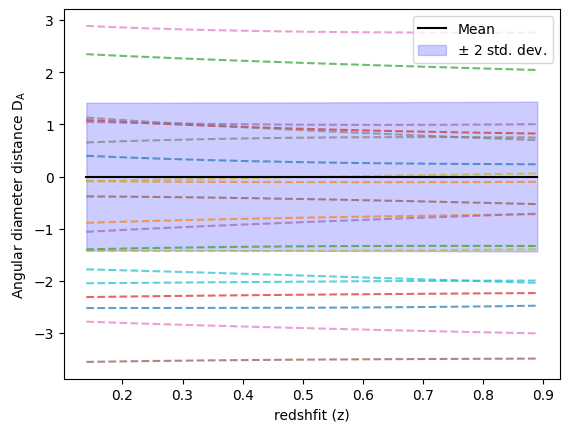

In [ ]:
fig, ax = plt.subplots()
plot_gpr_samples(gpr, z_pred, 20, ax)
#ax.set_title('Samples from prior disribution')
fig.show()

In [ ]:
gpr.fit(z_train, d_a_train)

print(
    f"Kernel parameters before fit:\n{kernel} \n"
    f"Kernel parameters after fit: \n{gpr.kernel_} \n"
    f"Log-likelihood: {gpr.log_marginal_likelihood(gpr.kernel_.theta):.3f} \n"
    f"Score = {gpr.score(z_train,d_a_train)}"
)

Kernel parameters before fit:
1**2 + 1**2 * DotProduct(sigma_0=1) ** 0.1 
Kernel parameters after fit: 
0.0964**2 + 7.94**2 * DotProduct(sigma_0=0.328) ** 0.1 
Log-likelihood: -49.633 
Score = 0.49415331093820336


/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:445: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:492: RuntimeWarning: covariance is not positive-semidefinite.
  y_samples = rng.multivariate_normal(y_mean, y_cov, n_samples).T


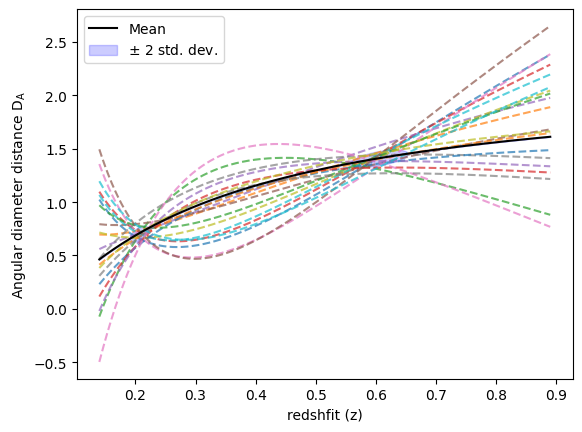

In [ ]:
fig, ax = plt.subplots()
plot_gpr_samples(gpr, z_pred, 20, ax)
#ax.set_title('Samples from posterior disribution')
fig.show()

In [ ]:
d_a_pred, sigma = gpr.predict(z_pred, return_std=True)
d_a_pred = d_a_pred.reshape(-1)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:445: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


<ipython-input-24-99f468b51103>:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  plt.errorbar(z, d_a, error, fmt='.k', color='black',


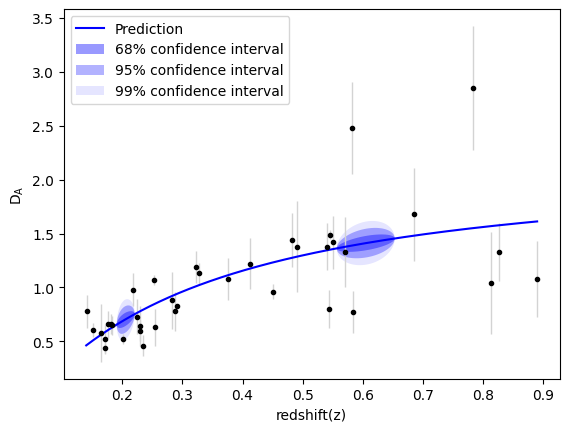

In [ ]:
#plt.figure(figsize=(7,5))
plt.errorbar(z, d_a, error, fmt='.k', color='black',
             ecolor='lightgray', elinewidth=1, capsize=0);
plt.plot(z_pred, d_a_pred, 'b-', label='Prediction',)
plt.fill_between(z_pred[:,0], d_a_pred-1*sigma, d_a_pred+1*sigma,
         alpha=.4, fc='b', ec='None', label='68% confidence interval')
plt.fill_between(z_pred[:,0], d_a_pred-2*sigma, d_a_pred+2*sigma,
         alpha=.3, fc='b', ec='None', label='95% confidence interval')
plt.fill_between(z_pred[:,0], d_a_pred-3*sigma, d_a_pred+3*sigma,
         alpha=.1, fc='b', ec='None', label='99% confidence interval')
plt.xlabel('redshift(z)')
plt.ylabel('$\mathregular{D_A}$')
plt.legend()
plt.show()

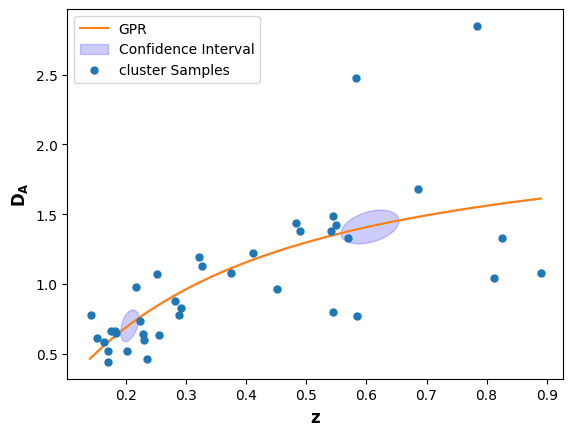

In [ ]:
upper, lower = d_a_pred + 1.68 * sigma, d_a_pred - 1.68 * sigma

plt.errorbar(z_train,d_a_train, fmt="o", label="cluster Samples", markersize=5)
# plt.plot(x_fine, y_fine, label="Function", color="w", lw=1)
plt.plot(z_pred, d_a_pred, label="GPR", ls="-")
plt.fill_between(z_pred.ravel(), upper, lower, alpha=0.2, label=r"Confidence Interval", color="#0000eb")
plt.xlabel("z",fontweight='bold',fontsize = 12)
plt.ylabel("$\mathregular{D_A}$",fontweight = 'bold',fontsize = 12)
plt.legend()
plt.show()

# GRB Dataset

In [ ]:
df_GRB = pd.read_csv('/content/drive/MyDrive/Thesis/GRB_data_2011.csv')
df_GRB.tail()

,GRB,z,P_bolo,P_bolo_err,S_bolo,S_bolo_err,F_beam,F_beam_err,T_lag,T_lag_err,V,V_err,E_peak,E_peak_err_min,E_peak_err_max,T_RT,T_RT_err
111,80605,1.64,5.990000e-06,1.100000e-07,0.000047,4.320000e-07,NaN,NaN,0.11,0.01,0.057,0.003,246.0,11.0,14.0,0.22,0.01
112,80607,3.04,8.350000e-06,2.420000e-07,0.000100,0.000000e+00,NaN,NaN,0.04,0.01,0.035,0.003,394.0,33.0,35.0,0.18,0.06
113,80707,1.23,1.680000e-07,1.020000e-08,0.000001,8.870000e-08,NaN,NaN,NaN,NaN,0.093,0.032,73.0,20.0,20.0,NaN,NaN
114,80721,2.60,9.570000e-06,5.010000e-07,0.000060,3.040000e-06,NaN,NaN,0.13,0.05,0.048,0.009,485.0,36.0,41.0,0.09,0.04
115,90423,8.20,2.170000e-07,1.550000e-08,0.000001,4.730000e-08,NaN,NaN,NaN,NaN,NaN,NaN,48.6,3.8,3.8,NaN,NaN


In [ ]:
df_GRB.shape

(116, 17)

* Since we have trained GPR on the data with redshift value between 0.142 to 0.89.

In [ ]:
df_GRB[df_GRB['z'].between(0.142, 0.89)]

# Specify the file path
file_path = '/content/drive/MyDrive/Thesis/filtered_GRB.xlsx'

# Save the DataFrame as an Excel file at the specified path
df_GRB[df_GRB['z'].between(0.142, 0.89)].to_excel(file_path, index=False)

In [ ]:
#Predicting D_a from the Z of GRB Dataset but value of Z is only between 0.142 and 0.89
df_filterd_GRB=pd.read_excel('/content/drive/MyDrive/Thesis/filtered_GRB.xlsx')
z_GRB = df_filterd_GRB['z'].to_numpy()
d_a_GRB, d_a_GRB_err = gpr.predict(z_GRB.reshape(-1,1), return_std=True)
df_filterd_GRB['D_A']=d_a_GRB
df_filterd_GRB['D_A_err']=d_a_GRB_err
d_a_GRB.shape

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:445: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


(27,)

## D_L calculation for GRB Dataset

In [ ]:
def calculate_dL(D_A,Z):
  # dL is the luminosity distance of GRB, which can be obtained from the reconstructed d_a moduli of galaxy cluster data
    D_L = D_A*((1+Z)**2)
    return D_L

In [ ]:
D_L=calculate_dL(d_a_GRB,z_GRB)
df_filterd_GRB['D_L']=D_L
D_L.shape

(27,)

## L calculation for GRB Dataset

In [ ]:
def calculate_L(D_L,P_bolo):
    L = 4*np.pi*(D_L**2)*P_bolo
    return L

In [ ]:
P_bolo = df_filterd_GRB['P_bolo'].to_numpy()
L=calculate_dL(D_L,P_bolo)
df_filterd_GRB['L']=L
L.shape

(27,)

## E_ISO calculation for GRB Dataset

In [ ]:
def calculate_E_ISO(D_L,S_bolo,z_GRB):
    E_ISO = (4*np.pi*(D_L**2)*S_bolo)/(1+z_GRB)
    return E_ISO

In [ ]:
S_bolo = df_filterd_GRB['S_bolo'].to_numpy()
E_ISO=calculate_E_ISO(D_L,S_bolo,z_GRB)
df_filterd_GRB['E_ISO']=E_ISO
E_ISO.shape

(27,)

## E_r Calculation for GRB Dataset

In [ ]:
def calculate_E_r(E_ISO,F_beam):
    E_r = E_ISO * F_beam
    return E_r

In [ ]:
F_beam=df_filterd_GRB['F_beam'].to_numpy()
E_r = calculate_E_r(E_ISO,F_beam)
df_filterd_GRB['E_r']=E_r
E_r.shape

(27,)

# Error Propagation

In [ ]:
df_filterd_GRB.head()

,GRB,z,P_bolo,P_bolo_err,S_bolo,S_bolo_err,F_beam,F_beam_err,T_lag,T_lag_err,...,E_peak_err_min,E_peak_err_max,T_RT,T_RT_err,D_A,D_A_err,D_L,L,E_ISO,E_r
0,970228,0.70,0.000007,4.300000e-07,NaN,NaN,NaN,NaN,NaN,NaN,...,38,38,NaN,NaN,1.492017,0.0,4.311929,4.311991,NaN,NaN
1,970508,0.84,0.000003,3.300000e-07,0.000008,8.100000e-07,0.07950,0.02040,0.49,0.02,...,40,40,0.65,0.07,1.584882,0.0,5.365778,5.365813,0.001591,0.000126
2,990705,0.84,0.000007,2.600000e-07,0.000134,1.500000e-05,0.00348,0.00096,NaN,NaN,...,15,15,0.62,0.37,1.584882,0.0,5.365778,5.365849,0.026349,0.000092
3,991208,0.71,0.000021,2.100000e-06,NaN,NaN,NaN,NaN,NaN,NaN,...,20,20,0.27,0.01,1.499568,0.0,4.384887,4.385072,NaN,NaN
4,210,0.85,0.000020,2.100000e-06,NaN,NaN,NaN,NaN,NaN,NaN,...,14,14,0.45,0.03,1.590593,0.0,5.443805,5.444022,NaN,NaN


### error in D_L

In [ ]:
def calculate_DL_err(z,d_a,z_err, d_a_err):
    return (((1+z)**2)*(d_a_err**2)) + (2*d_a*(1+z)*(z_err**2))

In [ ]:
z=df_filterd_GRB['z'].to_numpy()
d_a=df_filterd_GRB['D_A'].to_numpy()
#uncomment this next time
# d_a_GRB_err=df_filterd_GRB['D_A_err'].to_numpy()
DL_err = calculate_DL_err(z,d_a,0,d_a_GRB_err)
df_filterd_GRB['DL_err']=DL_err

### error in L

In [ ]:
def calculate_L_err(d_l,p_bolo,d_l_err, p_bolo_err):
    return (8*np.pi*d_l*p_bolo*(d_l_err**2)) + (4*np.pi*(d_l**2)*(p_bolo_err**2))

In [ ]:
d_l=df_filterd_GRB['D_L'].to_numpy()
P_bolo=df_filterd_GRB['P_bolo'].to_numpy()
P_bolo_err=df_filterd_GRB['P_bolo_err'].to_numpy()
L_err = calculate_L_err(d_l,P_bolo,DL_err,P_bolo_err)
df_filterd_GRB['L_err']=L_err

### error in E_ISO

In [ ]:
def calculate_E_ISO_err(d_l,s_bolo,z,d_l_err,s_bolo_err, z_err):
    return ((8*np.pi*d_l*s_bolo)/(1+z))*(d_l_err**2) + ((4*np.pi*(d_l**2))/(1+z))*(s_bolo_err**2) - ((4*np.pi*(d_l**2)*s_bolo)/(1+z)**2)*(z_err**2)

In [ ]:
S_bolo=df_filterd_GRB['S_bolo'].to_numpy()
S_bolo_err=df_filterd_GRB['S_bolo_err'].to_numpy()
E_ISO_err = calculate_E_ISO_err(d_l,S_bolo,z,DL_err,S_bolo_err,0)
df_filterd_GRB['E_ISO_err']=E_ISO_err

### error in E_r

In [ ]:
def calculate_Er_err(E_ISO,F_beam,E_ISO_err,F_beam_err):
    return (F_beam*(E_ISO_err**2)) + (E_ISO*(F_beam_err**2))

In [ ]:
E_ISO=df_filterd_GRB['E_ISO'].to_numpy()
F_beam=df_filterd_GRB['F_beam'].to_numpy()
F_beam_err=df_filterd_GRB['F_beam_err'].to_numpy()
E_r_error=calculate_Er_err(E_ISO,F_beam,E_ISO_err,F_beam_err)
df_filterd_GRB['E_r_error']=E_r_error

# Final GRB Dataset with all calculated values

* GRB Dataset with

1. D_L and D_L_error
2. L and L_error
3. E_ISO and E_ISO_error
4. E_r and E_r_error



In [ ]:
file_path = '/content/drive/MyDrive/Thesis/final_calculated_GRB.xlsx'

# Save the DataFrame as an Excel file at the specified path
df_filterd_GRB.to_excel(file_path, index=False)

# MCMC

In [ ]:
!pip install corner
!pip install -U emcee

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 2.6 MB/s eta 0:00:00


In [ ]:
import emcee
import corner

In [ ]:
GRB=pd.read_excel('/content/drive/MyDrive/Thesis/final_calculated_GRB.xlsx')
GRB.head()

,GRB,z,P_bolo,P_bolo_err,S_bolo,S_bolo_err,F_beam,F_beam_err,T_lag,T_lag_err,...,D_A,D_A_err,D_L,L,E_ISO,E_r,DL_err,L_err,E_ISO_err,E_r_error
0,970228,0.70,0.000007,4.300000e-07,NaN,NaN,NaN,NaN,NaN,NaN,...,1.492017,0.0,4.311929,4.311991,NaN,NaN,0.0,4.320061e-11,NaN,NaN
1,970508,0.84,0.000003,3.300000e-07,0.000008,8.100000e-07,0.07950,0.02040,0.49,0.02,...,1.584882,0.0,5.365778,5.365813,0.001591,0.000126,0.0,3.940063e-11,1.290112e-10,6.620126e-07
2,990705,0.84,0.000007,2.600000e-07,0.000134,1.500000e-05,0.00348,0.00096,NaN,NaN,...,1.584882,0.0,5.365778,5.365849,0.026349,0.000092,0.0,2.445806e-11,4.424253e-08,2.428313e-08
3,991208,0.71,0.000021,2.100000e-06,NaN,NaN,NaN,NaN,NaN,NaN,...,1.499568,0.0,4.384887,4.385072,NaN,NaN,0.0,1.065529e-09,NaN,NaN
4,210,0.85,0.000020,2.100000e-06,NaN,NaN,NaN,NaN,NaN,NaN,...,1.590593,0.0,5.443805,5.444022,NaN,NaN,0.0,1.642304e-09,NaN,NaN


In [ ]:
GRB['dL'] = GRB['D_L'].to_numpy()
GRB['dL_err'] = GRB['DL_err'].to_numpy()
GRB['L'] = GRB['L'].to_numpy()
GRB['L_err'] = GRB['L_err'].to_numpy()
GRB['E_iso'] = GRB['E_ISO'].to_numpy()
GRB['E_iso_err'] = GRB['E_ISO_err'].to_numpy()
GRB['E_gamma'] = GRB['E_r'].to_numpy()
GRB['E_gamma_err'] = GRB['E_r_error'].to_numpy()

In [ ]:
GRB['E_peak_err'] = GRB[['E_peak_err_min','E_peak_err_max']].mean(axis=1)

In [ ]:
GRB['T_lag_i'] = GRB['T_lag'] / (1. + GRB['z'])
GRB['T_lag_i_err'] = GRB['T_lag_err'] / (1. + GRB['z'])
GRB['T_RT_i'] = GRB['T_RT'] / (1. + GRB['z'])
GRB['T_RT_i_err'] = GRB['T_RT_err'] / (1. + GRB['z'])
GRB['V_i'] = GRB['V'] * (1. + GRB['z'])
GRB['V_i_err'] = GRB['V_err'] * (1. + GRB['z'])
GRB['E_peak_i'] = GRB['E_peak'] * (1. + GRB['z'])
GRB['E_peak_i_err'] = GRB['E_peak_err'] * (1. + GRB['z'])
GRB['E_peak_i_err_min'] = GRB['E_peak_err_min'] * (1. + GRB['z'])
GRB['E_peak_i_err_max'] = GRB['E_peak_err_max'] * (1. + GRB['z'])

In [ ]:
# normalized
GRB['_T_lag_i'] = GRB['T_lag_i'] / 0.1
GRB['_T_lag_i_err'] = GRB['T_lag_i_err'] / 0.1
GRB['_V_i'] = GRB['V_i'] / 0.02
GRB['_V_i_err'] = GRB['V_i_err'] / 0.02
GRB['_E_peak_i'] = GRB['E_peak_i'] / 300
GRB['_E_peak_i_err'] = GRB['E_peak_i_err'] / 300
GRB['_E_peak_i_err_min'] = GRB['E_peak_i_err_min'] / 300
GRB['_E_peak_i_err_max'] = GRB['E_peak_i_err_max'] / 300
GRB['_T_RT_i'] = GRB['T_RT_i'] / 0.1
GRB['_T_RT_i_err'] = GRB['T_RT_i_err'] / 0.1

In [ ]:
# log transformation
GRB['log_T_lag_i'] = np.log10(GRB['_T_lag_i'])
GRB['log_T_lag_i_err'] = abs(GRB['_T_lag_i_err'] / (GRB['_T_lag_i'] * np.log(10)))
GRB['log_V_i'] = np.log10(GRB['_V_i'])
GRB['log_V_i_err'] = abs(GRB['_V_i_err'] / (GRB['_V_i'] * np.log(10)))
GRB['log_E_peak_i'] = np.log10(GRB['_E_peak_i'])
GRB['log_E_peak_i_err'] = abs(GRB['_E_peak_i_err'] / (GRB['_E_peak_i'] * np.log(10)))
GRB['log_E_peak_i_err_min'] = abs(GRB['_E_peak_i_err_min'] / (GRB['_E_peak_i'] * np.log(10)))
GRB['log_E_peak_i_err_max'] = abs(GRB['_E_peak_i_err_max'] / (GRB['_E_peak_i'] * np.log(10)))
GRB['log_T_RT_i'] = np.log10(GRB['_T_RT_i'])
GRB['log_T_RT_i_err'] = abs(GRB['_T_RT_i_err'] / (GRB['_T_RT_i'] * np.log(10)))

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [ ]:
GRB['log_L'] = np.log10(GRB['L'])
GRB['log_L_err'] = abs(GRB['L_err'] / (GRB['L'] * np.log(10)))
GRB['log_E_iso'] = np.log10(GRB['E_iso'])
GRB['log_E_iso_err'] = abs(GRB['E_iso_err'] / (GRB['E_iso'] * np.log(10)))
GRB['log_E_gamma'] = np.log10(GRB['E_gamma'])
GRB['log_E_gamma_err'] = abs(GRB['E_gamma_err'] / (GRB['E_gamma'] * np.log(10)))

In [ ]:
# # split the data in to low-z, high-z and All-z
# low_z_GRB = GRB[GRB['z']<=1.4]
# high_z_GRB = low_z_GRB
# All_z_GRB = GRB

In [ ]:
# low_z_GRB.shape

(27, 70)

# Corner Plot

In [ ]:
def log_likelihood(theta, x, y, xerr, yerr):
    b, a, sigma_int = theta
    model = b * x + a
    sigma2 = sigma_int**2 + yerr**2 + b**2 * xerr**2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    b, a, sigma_int = theta
    if sigma_int > 0:
        return 0.0
    return -np.inf

def log_posterior(theta, x, y, xerr, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, xerr, yerr)

100%|██████████| 5000/5000 [00:08<00:00, 579.55it/s]


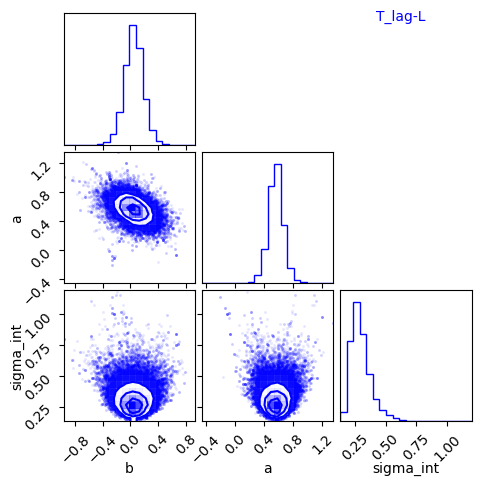

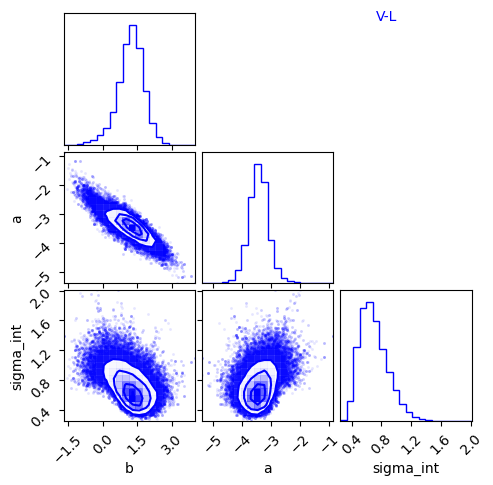

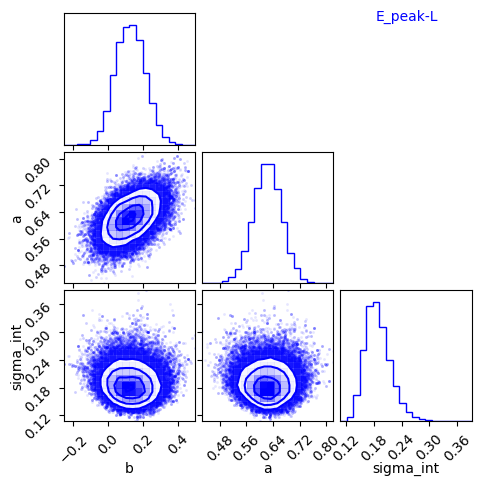

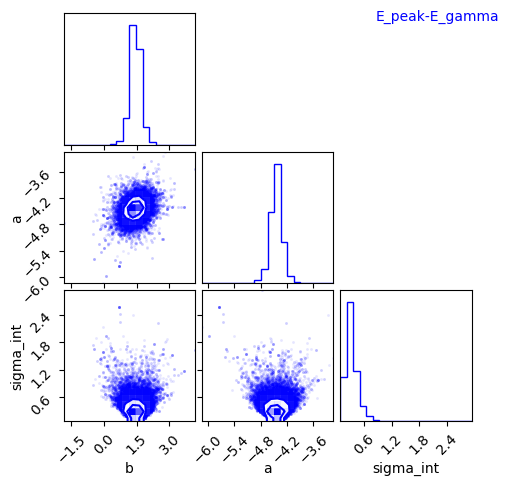

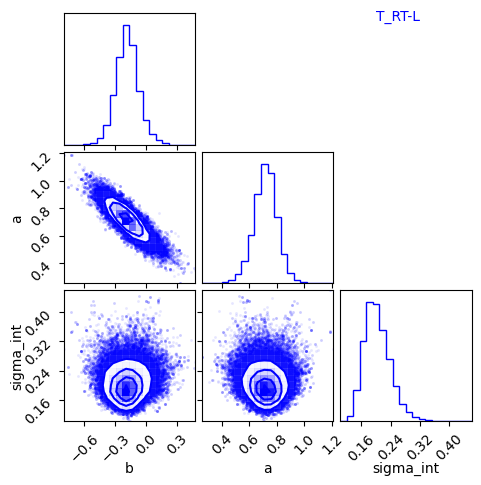

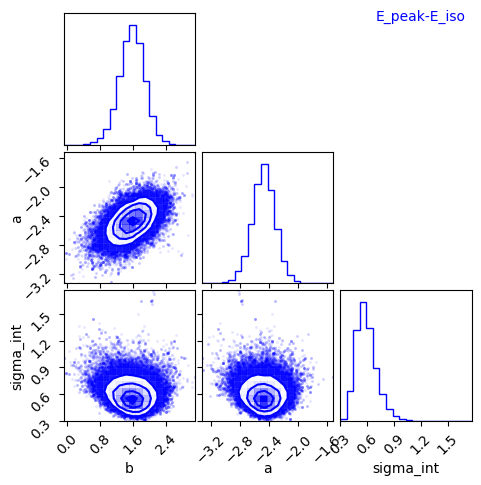

In [ ]:
correlations = {
    'T_lag-L' : ('log_T_lag_i', 'log_L', 'log_T_lag_i_err', 'log_L_err'),
    'V-L' : ('log_V_i', 'log_E_iso', 'log_V_i_err', 'log_E_iso_err'),
    'E_peak-L' : ('log_E_peak_i', 'log_L', 'log_E_peak_i_err', 'log_L_err'),
    'E_peak-E_gamma' : ('log_E_peak_i', 'log_E_gamma', 'log_E_peak_i_err', 'log_E_gamma_err'),
    'T_RT-L' : ('log_T_RT_i', 'log_L', 'log_T_RT_i_err', 'log_L_err'),
    'E_peak-E_iso' : ('log_E_peak_i', 'log_E_iso', 'log_E_peak_i_err', 'log_E_iso_err')
}

# Calculate best fit line with uncertainities(Bayesian approach) using emcee
GRB_samples = (GRB,)
sample_types =  ('GRB',)
colors = ('b',)

# MCMC parameters
nwalkers, ndim = 32, 3
nsteps, nburns = 5000, 1000

# empty dictionary to save best fit parameters and uncertainities
# BestFitParameters = {
#     'T_lag-L':{'low-z':None, 'high-z':None, 'All-z':None},
#     'V-L':{'low-z':None, 'high-z':None, 'All-z':None},
#     'E_peak-L':{'low-z':None, 'high-z':None, 'All-z':None},
#     'E_peak-E_gamma':{'low-z':None, 'high-z':None, 'All-z':None},
#     'T_RT-L':{'low-z':None, 'high-z':None, 'All-z':None},
#     'E_peak-E_iso':{'low-z':None, 'high-z':None, 'All-z':None}
# }

BestFitParameters = {
    'T_lag-L':{'GRB':None},
    'V-L':{'GRB':None},
    'E_peak-L':{'GRB':None},
    'E_peak-E_gamma':{'GRB':None},
    'T_RT-L':{'GRB':None},
    'E_peak-E_iso':{'GRB':None}
}

num = 8
for i, correlation in enumerate(correlations):

    luminosities = correlations[correlation]

    '''
    # create empty figure object for time series (steps) plot of parameters in chain
    fig1 = plt.figure(constrained_layout=True, figsize=(15,5))
    gs1 = gridspec.GridSpec(nrows=1, ncols=3, figure=fig1)
    '''

    # create empty figure object for corner plots (confidence contours and marginalized PDFs of parameters)
    fig2 = plt.figure(figsize=(5, 5))
    fig2.patch.set_facecolor('white')

    for k, (GRB_sample, sample_type, color) in enumerate(zip(GRB_samples, sample_types, colors)):

        df = GRB_sample.filter(luminosities).dropna()

        x = df[luminosities[0]].to_numpy()
        y = df[luminosities[1]].to_numpy()
        xerr = df[luminosities[2]].to_numpy()
        yerr = df[luminosities[3]].to_numpy()

        starting_guesses = np.random.rand(nwalkers, ndim)

        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, xerr, yerr))
        sampler.run_mcmc(starting_guesses, nsteps, progress=True)

        labels = ['b', 'a', 'sigma_int']

        # corner plots
        flat_samples = sampler.get_chain(discard=nburns, flat=True)
        corner.corner(flat_samples, labels=labels, color=color,fig=fig2)

        # save best fit values(mean) and uncertainities(std) of parameters in a dictionary
        BestFitParameters[correlation][sample_type] = {
                'a' : np.mean(flat_samples[:, 1]),
                'a_err' : np.std(flat_samples[:, 1]),
                'b' : np.mean(flat_samples[:, 0]),
                'b_err' : np.std(flat_samples[:, 0]),
                'sigma_int' : np.mean(flat_samples[:, 2]),
                'sigma_int_err' : np.std(flat_samples[:, 2])
        }

        fig2.axes[0].annotate(correlation, xy=(0.95*2.5, 0.95-k*0.2), xycoords='axes fraction',color=color)
        from IPython.display import display, Math

    #fig2.suptitle(correlation)

    #fig1.savefig('time_series_of_params.pdf')
    num_str = '0' + str(num) if num < 10 else str(num)
    fig2.savefig(correlation+'_corner_plot.pdf')
    num += 1
    #fig1.show()
    fig2.show()

# parameters values

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle

In [ ]:
with open('BestFitParameters.pickle', 'wb') as handle:
    pickle.dump(BestFitParameters, handle)

In [ ]:
with open('BestFitParameters.pickle', 'rb') as handle:
    BestFitParameters = pickle.load(handle)

In [ ]:
def flatten_dict(nested_dict):
    res = {}
    if isinstance(nested_dict, dict):
        for k in nested_dict:
            flattened_dict = flatten_dict(nested_dict[k])
            for key, val in flattened_dict.items():
                key = list(key)
                key.insert(0, k)
                res[tuple(key)] = val
    else:
        res[()] = nested_dict
    return res


def nested_dict_to_df(values_dict):
    flat_dict = flatten_dict(values_dict)
    df = pd.DataFrame.from_dict(flat_dict, orient="index")
    df.index = pd.MultiIndex.from_tuples(df.index)
    df = df.unstack(level=-1)
    df.columns = df.columns.map("{0[1]}".format)
    return df

table = nested_dict_to_df(BestFitParameters)

!pip install tabulate

from tabulate import tabulate

print(tabulate(table, headers='keys', tablefmt='fancy_grid'))

╒═══════════════════════════╤═══════════╤═══════════╤════════════╤═══════════╤═════════════╤═════════════════╕
│                           │         a │     a_err │          b │     b_err │   sigma_int │   sigma_int_err │
╞═══════════════════════════╪═══════════╪═══════════╪════════════╪═══════════╪═════════════╪═════════════════╡
│ ('E_peak-E_gamma', 'GRB') │ -4.44697  │ 0.140672  │  1.43143   │ 0.259921  │    0.335673 │       0.152011  │
├───────────────────────────┼───────────┼───────────┼────────────┼───────────┼─────────────┼─────────────────┤
│ ('E_peak-E_iso', 'GRB')   │ -2.47432  │ 0.161768  │  1.56583   │ 0.317142  │    0.594658 │       0.120487  │
├───────────────────────────┼───────────┼───────────┼────────────┼───────────┼─────────────┼─────────────────┤
│ ('E_peak-L', 'GRB')       │  0.623043 │ 0.043082  │  0.126617  │ 0.0854989 │    0.188655 │       0.0282104 │
├───────────────────────────┼───────────┼───────────┼────────────┼───────────┼─────────────┼─────────────────┤
│

# Regression Work

In [ ]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')
    plt.show()

<ipython-input-114-c3f2d755862f>:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='.k', color='black',
<ipython-input-114-c3f2d755862f>:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='.k', color='black',
<ipython-input-114-c3f2d755862f>:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='.k', color='black',
<ipython-input-114-c3f2d755862f>:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string ".k" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x,y,xerr=xerr,yerr=ye

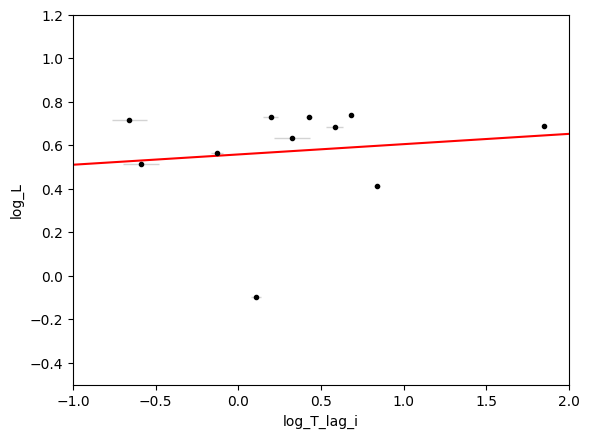

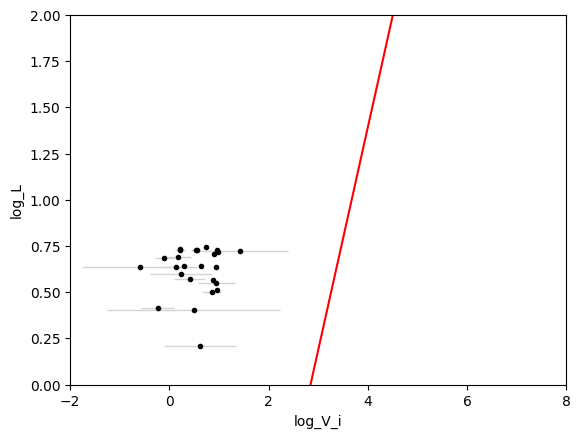

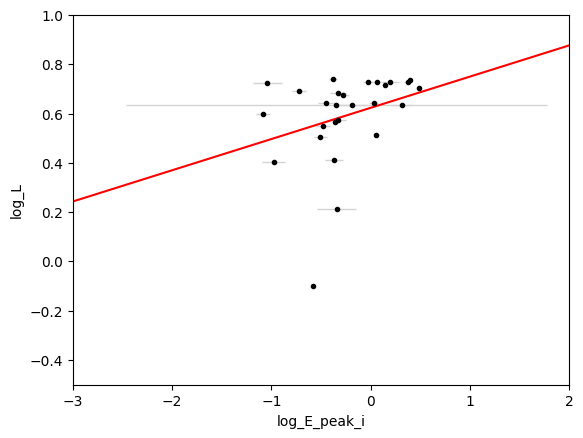

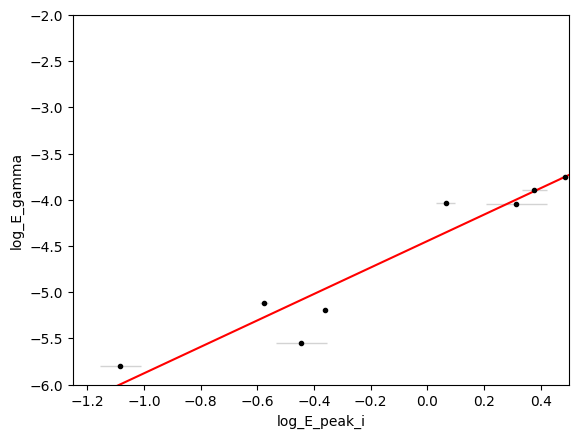

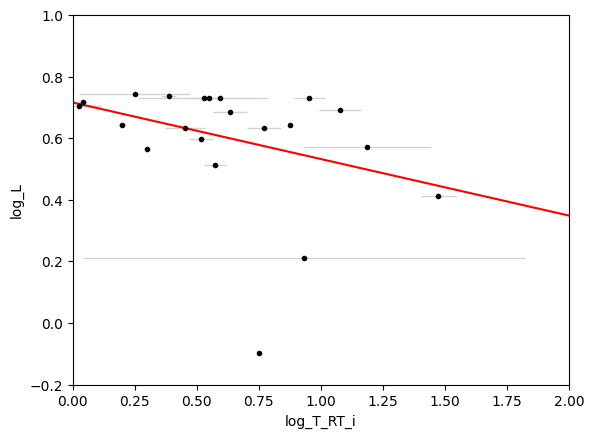

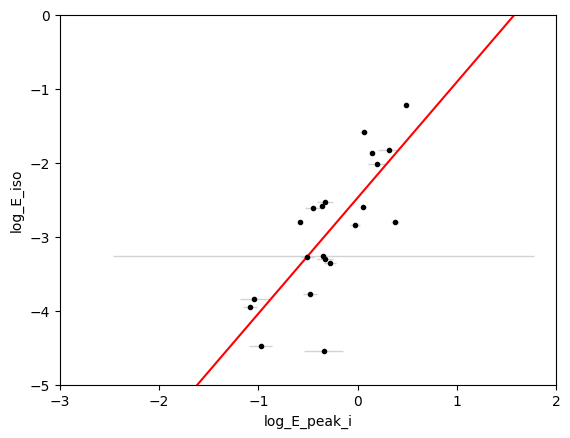

In [ ]:
correlations = {
    'T_lag-L' : {'features': ('log_T_lag_i', 'log_L', 'log_T_lag_i_err', 'log_L_err'), 'ylim':(-0.5, 1.2), 'xlim':(-1.0,2.0)},
    'V-L' : {'features': ('log_V_i', 'log_L', 'log_V_i_err', 'log_L_err'), 'ylim':(0, 2), 'xlim':(-2,8)},
    'E_peak-L' : {'features': ('log_E_peak_i', 'log_L', 'log_E_peak_i_err', 'log_L_err'), 'ylim':(-0.5, 1), 'xlim':(-3,2)},
    'E_peak-E_gamma' : {'features': ('log_E_peak_i', 'log_E_gamma', 'log_E_peak_i_err', 'log_E_gamma_err'), 'ylim':(-6, -2), 'xlim':(-1.25,0.5)},
    'T_RT-L' : {'features': ('log_T_RT_i', 'log_L', 'log_T_RT_i_err', 'log_L_err'), 'ylim':(-0.2, 1), 'xlim':(0,2.0)},
    'E_peak-E_iso' : {'features': ('log_E_peak_i', 'log_E_iso', 'log_E_peak_i_err', 'log_E_iso_err'), 'ylim':(-5, 0), 'xlim':(-3,2)}
}

GRB_samples = (GRB,)
sample_types =  ('GRB',)
colors = ('r',)



for i, correlation in enumerate(correlations):

    fig, ax = plt.subplots()
    fig.patch.set_facecolor('white')

    luminosities = correlations[correlation]['features']

    for GRB_sample, sample_type, color in zip(GRB_samples, sample_types, colors):

        df = GRB_sample.filter(luminosities).dropna()

        x = df[luminosities[0]].to_numpy()
        y = df[luminosities[1]].to_numpy()
        xerr = df[luminosities[2]].to_numpy()
        yerr = df[luminosities[3]].to_numpy()

        ax.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='.k', color='black',
             ecolor='lightgray', elinewidth=1, capsize=0, label=sample_type)


        # abline(BestFitParameters[correlation][sample_type]['a'], BestFitParameters[correlation][sample_type]['b'])
        ax.plot(
            np.linspace(-3,8,1000),
            BestFitParameters[correlation][sample_type]['a'] + BestFitParameters[correlation][sample_type]['b'] * np.linspace(-3,8,1000),
            #luminosity_correlation_fit(np.linspace(-2,2,100), 'T_lag-L', sample_type),
            linestyle='-', color=color, label=sample_type +' best fit'
            )


    ax.set_xlabel(luminosities[0])
    ax.set_ylabel(luminosities[1])
    ax.set_ylim(correlations[correlation]['ylim'])
    ax.set_xlim(correlations[correlation]['xlim'])

    # ax.legend()

    plt.savefig(correlation+'regression.pdf')
    fig.show()